In [4]:
import keras
from keras.applications.nasnet import NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.utils import np_utils
from keras import optimizers
from matplotlib import pyplot as plt
from keras.datasets import cifar10
import numpy as np
from keras.callbacks import LearningRateScheduler
from scipy.misc import toimage

Using TensorFlow backend.


c:\users\abhay\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


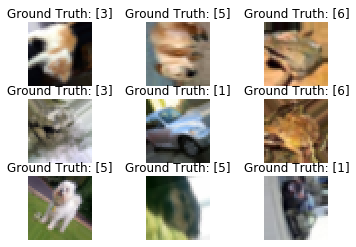

Shape of training data: (50000, 32, 32, 3) (50000, 1)
Shape of testing data: (10000, 32, 32, 3) (10000, 1)


In [17]:
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.axis('off')
        plt.title('Ground Truth: {}'.format(y_batch[i]))
        plt.imshow(toimage(X_batch[i].reshape(32, 32, 3)))
    # show the plot
    plt.show()
    break
    
print("Shape of training data: {} {}".format(x_train.shape,y_train.shape))
print("Shape of testing data: {} {}".format(x_test.shape,y_test.shape))

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_generator = train_datagen.flow_from_directory('./data', target_size=(224, 224), color_mode='rgb', batch_size=20, class_mode='categorical',subset='training')
valid_generator = train_datagen.flow_from_directory('./data', target_size=(224, 224), color_mode='rgb', batch_size=20, class_mode='categorical',subset='validation')


Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [5]:
model = NASNetMobile(input_shape = (224,224,3), include_top = False, weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
for layer in model.layers[:5]:
    layer.trainable = False

In [7]:
x = model.output
x = layers.Flatten()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dense(10,activation='softmax')(x)

network = keras.models.Model(model.input,x)
network.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           stem_bn1[0][0]              

activation_166 (Activation)     (None, 7, 7, 176)    0           normal_bn_1_11[0][0]             
__________________________________________________________________________________________________
activation_168 (Activation)     (None, 7, 7, 176)    0           adjust_bn_11[0][0]               
__________________________________________________________________________________________________
activation_170 (Activation)     (None, 7, 7, 176)    0           adjust_bn_11[0][0]               
__________________________________________________________________________________________________
activation_172 (Activation)     (None, 7, 7, 176)    0           adjust_bn_11[0][0]               
__________________________________________________________________________________________________
activation_174 (Activation)     (None, 7, 7, 176)    0           normal_bn_1_11[0][0]             
__________________________________________________________________________________________________
separable_

In [22]:
network.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
import timeit

start = timeit.default_timer()

model_train = network.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 20,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 20,
    epochs = 25)

Epoch 1/25
2000/2000 [==============================] - 4108s 2s/step - loss: 4.3188 - acc: 0.2594 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/25
1106/2000 [===============>..............] - ETA: 29:04 - loss: 1.7183 - acc: 0.4077

KeyboardInterrupt: 

In [ ]:
stop = timeit.default_timer()
final_time = stop - start
print('Time Taken: ', final_time/3600)
network.save('NNet50_cifar10.h5py')